In [35]:
import numpy as np
import pandas as pd
import datetime
import timeit
import os
import csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [36]:
%reload_ext autoreload
%autoreload 2

In [37]:
def convert_date(str):
    """
    This method is used to convert a string into datetime.
    """
    arr = str.split("-")
    year = int(arr[0])
    month = int(arr[1])

    str = arr[2]
    arr = str.split()
    day = int(arr[0])
    date = datetime.datetime(year = year, month = month, day = day)
    return date

## Get Data

In [38]:
 test = pd.read_csv("../input/two-data/test.csv")
data = pd.read_csv("../input/two-data/train.csv")
'''
data = pd.read_csv("data/train.csv")
test = pd.read_csv('data/test.csv')
display(data.head())
display(test.head())
'''

'\ndata = pd.read_csv("data/train.csv")\ntest = pd.read_csv(\'data/test.csv\')\ndisplay(data.head())\ndisplay(test.head())\n'

## Column selection and categorization

In [39]:
data = data.loc[data['CATERGORY'] == 'Bananas']
data

,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
47,71a47b20-65cf-44cf-b759-1e6a22894e54,1.292,1.59,2010,2010.0,Banana Cavendish,2.0,1.99,2016-03-17 10:37:16,cash,5.336462,no ID,Bananas
59,fe6687ab-205a-4713-b07a-4319a36a6327,1.254,1.59,2010,2010.0,Banana Cavendish,2.0,1.99,2016-03-17 10:46:28,cash,20.067160,no ID,Bananas
92,c1e1c457-80c8-4c5d-b384-ba68a0750d21,0.828,1.59,2010,2010.0,Banana Cavendish,2.0,1.99,2016-03-17 11:07:38,cash,62.437462,no ID,Bananas
100,15a336e0-d1b8-4190-ae21-230c7b19175e,0.956,1.59,2010,2010.0,Banana Cavendish,2.0,1.99,2016-03-17 11:10:34,cash,6.006880,no ID,Bananas
103,d24bbcd9-bfab-4e9f-a890-6382de2427f6,0.822,1.59,2010,2010.0,Banana Cavendish,2.0,1.99,2016-03-17 11:11:32,magcard,3.623580,482881061639,Bananas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
529919,63cea9d3-dc7e-4de6-ae50-4bf8dc8b0de0,0.908,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2018-12-31 17:26:57,cash,13.749700,no ID,Bananas
529936,20cbe698-ece6-419c-9a8f-89db911b7926,1.118,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2018-12-31 17:48:12,magcard,22.246160,891189246880,Bananas
529951,4070f4d0-3763-424d-b9e4-ab68e662e5fa,1.524,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2018-12-31 18:20:24,cash,20.552760,no ID,Bananas
529959,19ebd170-5662-44aa-9af6-ef3bc81c994c,0.926,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2018-12-31 18:35:58,magcard,14.302340,756916459083,Bananas


### Sort by date and assign number to it

In [40]:
date = data['DATENEW'].apply(convert_date)
date

47       2016-03-17
59       2016-03-17
92       2016-03-17
100      2016-03-17
103      2016-03-17
            ...    
529919   2018-12-31
529936   2018-12-31
529951   2018-12-31
529959   2018-12-31
529962   2018-12-31
Name: DATENEW, Length: 36779, dtype: datetime64[ns]

In [41]:
data['DATENEW'] = date
data = data[["DATENEW", "UNITS"]].groupby('DATENEW').sum().reset_index()
data = data.sort_values(by = "DATENEW", ascending = True)
data

,DATENEW,UNITS
0,2016-03-17,21.344
1,2016-03-18,20.408
2,2016-03-19,30.732
3,2016-03-20,16.268
4,2016-03-21,21.618
...,...,...
997,2018-12-24,27.786
998,2018-12-28,12.200
999,2018-12-29,25.734
1000,2018-12-30,18.176


## Building Model

In [42]:
test_df = test.loc[test['CATERGORY'] == 'Bananas']
test_df

,TICKET,UNITS,PRICE,REFERENCE,CODE,NAME,PRICEBUY,PRICESELL,DATENEW,PAYMENT,TOTAL,TRANSID,CATERGORY
0,7394a47a-778b-4299-bc0b-204c803204fd,1.980,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2019-01-02 08:09:57,cash,3.95020,no ID,Bananas
8,17079ce3-7a0b-4fbb-a762-977a3ae79667,1.082,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2019-01-02 08:34:09,cash,14.49868,no ID,Bananas
10,aa078592-0d13-48ff-9d74-3bc75892011e,1.116,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2019-01-02 08:35:23,cash,11.70084,no ID,Bananas
15,810e59b8-d23a-479d-b4d8-81bcd05953cb,0.710,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2019-01-02 08:36:40,cash,9.04570,no ID,Bananas
27,95ab7fce-1164-48a2-8783-0977dfde35ae,0.934,1.99,2010,2010.0,Banana Cavendish,2.0,1.99,2019-01-02 09:16:44,cash,8.85466,no ID,Bananas
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129134,45b5b4d2-0c2f-4a56-8ffd-cd3e192c6c9e,0.746,3.50,2010,2010.0,Banana Cavendish,2.0,1.99,2019-10-13 13:24:56,cash,5.49542,no ID,Bananas
129154,ce3e4720-9219-4e50-88de-cbe178f4044d,1.444,3.50,2010,2010.0,Banana Cavendish,2.0,1.99,2019-10-13 15:06:34,magcard,22.94530,592150417280,Bananas
129193,668fc6a3-40ec-4af7-9188-bf94895675e4,0.894,3.50,2010,2010.0,Banana Cavendish,2.0,1.99,2019-10-13 16:01:22,magcard,30.40102,880304475478,Bananas
129210,9374097f-d3da-454c-a222-9f69721eeaa2,1.188,3.50,2010,2010.0,Banana Cavendish,2.0,1.99,2019-10-13 16:30:35,magcard,11.09760,633796691765,Bananas


In [43]:
date = test_df['DATENEW'].apply(convert_date)
test_df['DATENEW'] = date
test_df = test_df[["DATENEW", "UNITS"]].groupby('DATENEW').sum().reset_index()
test_df = test_df.sort_values(by = "DATENEW", ascending = True)
test_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,DATENEW,UNITS
0,2019-01-02,52.330
1,2019-01-03,30.684
2,2019-01-04,23.248
3,2019-01-05,32.950
4,2019-01-06,17.636
...,...,...
272,2019-10-09,16.128
273,2019-10-10,20.832
274,2019-10-11,18.468
275,2019-10-12,15.384


### Save datasets

In [44]:
'''
data.set_index('DATENEW').to_csv('data/Bananas data.csv')
'''

"\ndata.set_index('DATENEW').to_csv('data/Bananas data.csv')\n"

In [45]:
'''
test_df.set_index('DATENEW').to_csv('data/Bananas test.csv')
'''

"\ntest_df.set_index('DATENEW').to_csv('data/Bananas test.csv')\n"

In [46]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [47]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
sale_series = data['UNITS']
# transform data to be stationary
train_raw_values = sale_series.values
diff_values = difference(train_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
train = supervised.values

sale_series = test_df['UNITS']
# transform data to be stationary
test_raw_values = sale_series.values
diff_values = difference(test_raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
test = supervised.values

In [48]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1, 4)
# forecast the entire training dataset to build up state for forecasting
predictions = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(train_raw_values, yhat, len(train_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = train_raw_values[i]
rmse = np.sqrt(mean_squared_error(train_raw_values[:-1], predictions))
print('Train RMSE: %.3f' % rmse)

Train RMSE: 3.328


In [49]:
# cross validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(test_raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = test_raw_values[i]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=54.181266, Expected=52.330000
Predicted=37.733506, Expected=30.684000
Predicted=30.802608, Expected=23.248000
Predicted=35.905427, Expected=32.950000
Predicted=23.850442, Expected=17.636000
Predicted=34.571392, Expected=34.918000
Predicted=41.443292, Expected=44.626000
Predicted=37.424931, Expected=38.020000
Predicted=27.537313, Expected=24.222000
Predicted=29.508375, Expected=27.978000
Predicted=25.266936, Expected=22.590000
Predicted=25.434828, Expected=23.666000
Predicted=25.654630, Expected=24.548000
Predicted=29.004038, Expected=29.616000
Predicted=24.641534, Expected=23.320000
Predicted=27.551780, Expected=27.786000
Predicted=23.864406, Expected=22.522000
Predicted=23.789796, Expected=22.778000
Predicted=24.018127, Expected=23.368000
Predicted=30.362233, Expected=32.518000
Predicted=31.060337, Expected=32.680000
Predicted=24.831422, Expected=23.402000
Predicted=19.958373, Expected=16.960000
Predicted=18.168247, Expected=15.330000
Predicted=30.069542, Expected=33.262000


Test RMSE: 2.170


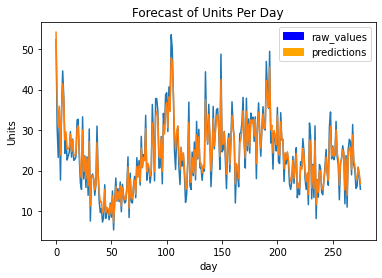

In [50]:
# report performance
rmse = np.sqrt(mean_squared_error(test_raw_values[:-1], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(test_raw_values[:-1])
plt.plot(predictions)
blue_patch = mpatches.Patch(color='blue', label='raw_values')
orange_patch = mpatches.Patch(color='orange', label='predictions')
plt.legend(handles=[blue_patch, orange_patch])
plt.ylabel('Units')
plt.xlabel('day')
plt.title('Forecast of Units Per Day')
plt.show()

## Save to csv

In [51]:
pred_df = pd.DataFrame(predictions)
pred_df.index = test_df['DATENEW'][:-1]
pred_df.columns = ['Bananas']
pred_df

,Bananas
DATENEW,
2019-01-02,54.181266
2019-01-03,37.733506
2019-01-04,30.802608
2019-01-05,35.905427
2019-01-06,23.850442
...,...
2019-10-08,17.862714
2019-10-09,17.785963
2019-10-10,20.786972


In [52]:
'''
path = os.path.join('predictions', 'Bananas lstm prediction.csv')
pred_df.to_csv(path)
'''

"\npath = os.path.join('predictions', 'Bananas lstm prediction.csv')\npred_df.to_csv(path)\n"

# Find Elbow Point

In [53]:
# fit an LSTM network to training data
batch_size = 1
nb_epoch = 8
result = pd.DataFrame(columns = ['time', 'rmse', 'nb_epoch', 'neurons'])
for neurons in range(1, 101):
    #training part
    X, y = train_scaled[:, 0:-1], train_scaled[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    test_code = '''
model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    '''
    time_cost = timeit.timeit(stmt = test_code, setup = 'from __main__ import ' + ', '.join(globals()), number = 1)

    #predicting part
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(model, batch_size, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(test_raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = test_raw_values[i]
    rmse = np.sqrt(mean_squared_error(test_raw_values[:-1], predictions))

    #append to result
    result = result.append(pd.DataFrame({'time': [time_cost], 'rmse': rmse, 'nb_epoch': nb_epoch, 'neurons': neurons}))
result

,time,rmse,nb_epoch,neurons
0,12.900589,5.146800,8,1
0,12.676844,6.105534,8,2
0,12.450278,5.452050,8,3
0,12.846123,5.254353,8,4
0,12.536493,5.162951,8,5
...,...,...,...,...
0,15.085647,4.768526,8,96
0,15.637774,4.898055,8,97
0,15.516803,4.899031,8,98
0,15.910511,4.788047,8,99


Text(0.5, 1.0, 'Time vs RMSE')

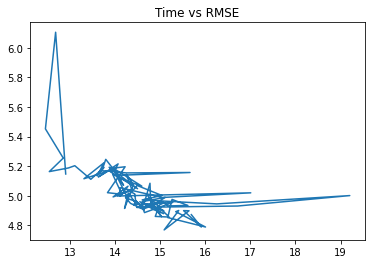

In [54]:
plt.scatter(result['time'], result['rmse'])
plt.title('Time vs RMSE')